In [18]:
import numpy as np
import pandas as pd
import ast
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import tqdm

In [ ]:
processed_path = '../Data/Processed/sub01_binned.csv'
eeg_data = pd.read_csv(processed_path)

eeg_task_path = '../Data/Processed/sub01_binned_task.csv'
eeg_task = pd.read_csv(eeg_task_path)

In [20]:
def transform_data_with_pca(eeg_data, n_components, max_length=2048):
    """
    Transforms EEG data using PCA with the specified number of components.
    """
    flattened_data = []
    
    # Drop non-electrode columns like 'label' and 'label_type'
    eeg_data_filtered = eeg_data.drop(columns=['label', 'label_type'])
    
    # Flatten the data for each trial across all electrodes
    for trial in range(eeg_data.shape[0]):
        trial_data = []
        for col in eeg_data_filtered.columns:
            # Convert string to list
            channel_data = ast.literal_eval(eeg_data_filtered[col].iloc[trial])
            
            # Truncate or pad the list to max_length
            if len(channel_data) > max_length:
                channel_data = channel_data[:max_length]
            else:
                channel_data = channel_data + [0] * (max_length - len(channel_data))
            
            # Append the flattened channel data
            trial_data.extend(channel_data)
        
        flattened_data.append(trial_data)
    
    # Convert to NumPy array
    flattened_data = np.array(flattened_data)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(flattened_data)
    
    return reduced_data

In [21]:
def evaluate_random_forest_with_pca(eeg_data, components_list, max_length=2048):
    """
    Evaluates a Random Forest classifier using different numbers of PCA components.
    """
    labels = eeg_data['label_type']  # Use 'label_type' for classification
    scores = []

    for n_components in tqdm.tqdm(components_list, desc='RF for PCA Components'):
        print(f"Evaluating with {n_components} PCA components...")
        
        # Transform data using PCA
        reduced_data = transform_data_with_pca(eeg_data, n_components, max_length)
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(reduced_data, labels, test_size=0.3, random_state=42)
        
        # Train a Random Forest classifier
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        scores.append(score)
        
        print(f"Accuracy with {n_components} components: {score:.4f}")

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(components_list, scores, marker='o', linestyle='--')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.title('Random Forest Accuracy vs. Number of PCA Components')
    plt.grid(True)
    plt.show()

    return scores

RF for PCA Components:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating with 100 PCA components...


RF for PCA Components:  33%|███▎      | 1/3 [01:13<02:26, 73.39s/it]

Accuracy with 100 components: 0.5312
Evaluating with 175 PCA components...


RF for PCA Components:  67%|██████▋   | 2/3 [02:26<01:12, 72.99s/it]

Accuracy with 175 components: 0.3750
Evaluating with 240 PCA components...


RF for PCA Components: 100%|██████████| 3/3 [03:39<00:00, 73.14s/it]

Accuracy with 240 components: 0.4479


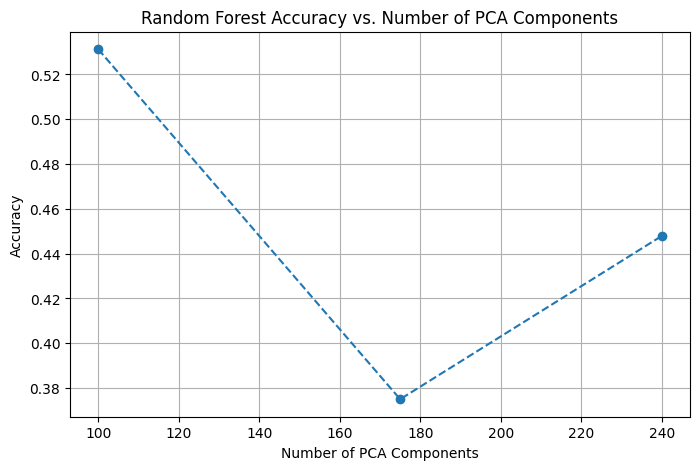

In [24]:
components_list = [100, 175, 240]
scores = evaluate_random_forest_with_pca(eeg_task, components_list, max_length=1023)

In [23]:
for n, score in zip(components_list, scores):
    print(f"Accuracy with {n} PCA components: {score:.4f}")

Accuracy with 5 PCA components: 0.5833
Accuracy with 6 PCA components: 0.5625
